In [1]:
from scgenome import tantalus
import pandas as pd
from IPython.display import display
from scgenome import utils, cncluster, simulation, cnplot
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import sklearn.metrics as skm

In [2]:
all_cn_data_fp = "/Users/massoudmaher/data/sc_1935_1936_1937_cn_data_qc.csv"
all_cn_data = pd.read_csv(all_cn_data_fp).iloc[:,1:]

In [3]:
uniq_cells = pd.Series(np.unique(all_cn_data["cell_id"]))
ends = np.unique(all_cn_data["end"])

In [10]:
# bhc params
n_states = 8
alpha = 10
prob_cn_change = 0.8

In [6]:
n_cell = 125
def sub_cn_data(n_cell, cnd, uniq_cells):
    keep_cells = list(uniq_cells.sample(n_cell))
    sub_cn = cnd.loc[cnd["cell_id"].isin(keep_cells)]
    return sub_cn

sub_cn = sub_cn_data(n_cell, all_cn_data, uniq_cells)

In [11]:
bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
        cncluster.bayesian_cluster(sub_cn, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change,
                                   clustering_id="copy")
)

/Users/massoudmaher/Documents/Code/scgenome/scg/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


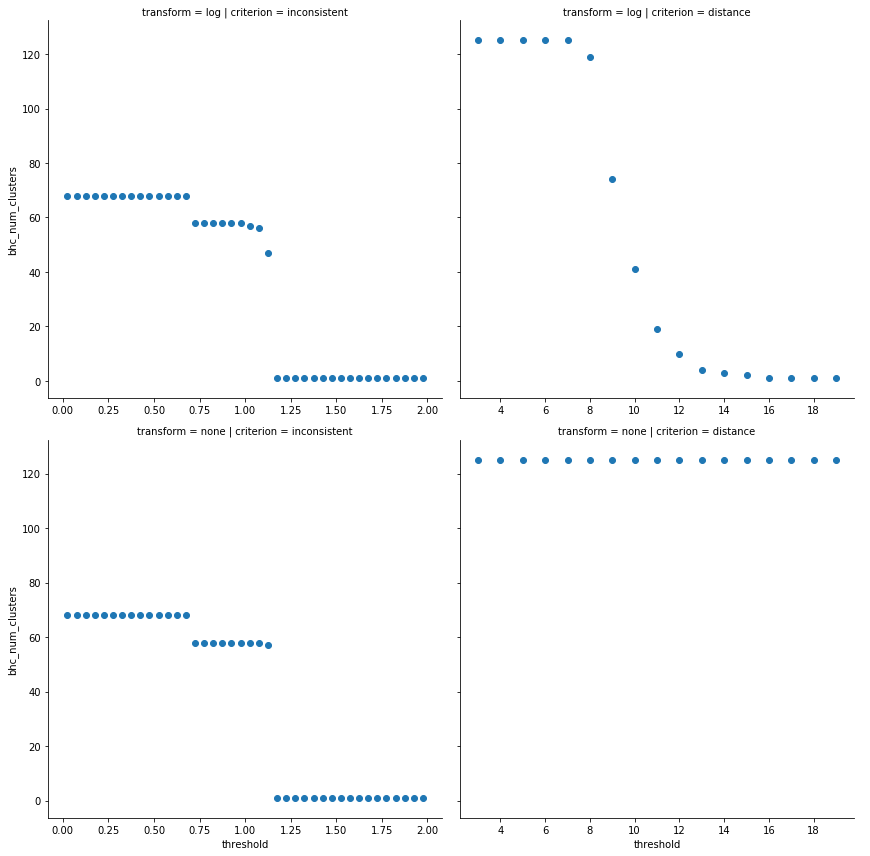

In [13]:
# Params for testing threshold values
params = simulation.expand_grid({"transform":["log","none"], "criterion": ["inconsistent"], "threshold": np.arange(0.025, 2, step=0.05)})
params = pd.concat([params, simulation.expand_grid({"transform":["log","none"], "criterion": ["distance"], "threshold": np.arange(3, 20, step=1)})])

bhc_linkage, bhc_plot_data = simulation.get_plot_data(bhc_linkage)
lbhc_plot_data = bhc_plot_data.copy()
lbhc_plot_data[:,2] = np.log(bhc_plot_data[:,2]) # Log because the highest link is way higher

def apply_fn(row):
    if row["transform"] == "log":
        df = lbhc_plot_data
    else:
        df = bhc_plot_data
    return sch.fcluster(df, row["threshold"], criterion=row["criterion"])
params["bhc_fcluster"] = params.apply(apply_fn, axis=1)
params["bhc_num_clusters"] = params["bhc_fcluster"].apply(lambda x: len(set(x)))

g = sns.FacetGrid(data=params, col="criterion", row="transform", size=6, sharey=True, sharex=False).add_legend()
g = g.map(plt.scatter, "threshold", "bhc_num_clusters")

ZeroDivisionError: float division by zero

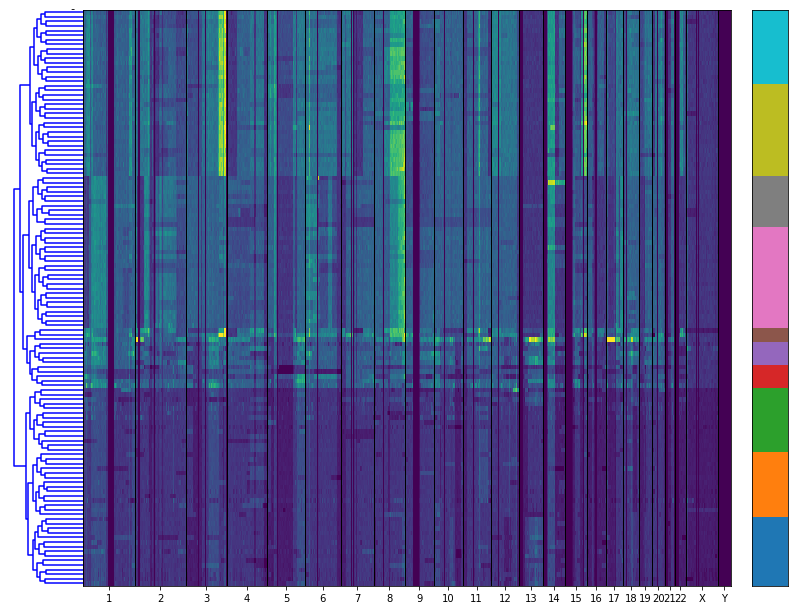

In [18]:
bhc_clusters = sch.fcluster(lbhc_plot_data, 12, criterion="distance")
assert len(set(bhc_clusters)) > 1
sub_cn = cncluster.prune_cluster(bhc_clusters, bhc_cell_ids, sub_cn)
#sub_cn["origin_id_int"] = sub_cn["origin_id"].factorize()[0]
sub_cn["origin_id_int"] = 0

fig = plt.figure(figsize=(10, 8))
bimatrix_data, ps = cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, sub_cn, "copy", cluster_field_name="bhc_cluster_id",
    linkage=lbhc_plot_data, origin_field_name="origin_id_int", raw=True, flip=True, cell_id_order = bhc_cell_ids)
clabels = get_mixture_labels(sub_cn)
scores = skm.homogeneity_completeness_v_measure(clabels["origin_id_int"], clabels["bhc_cluster_id"])
print(f"homogeneity: {scores[0]}, completeness: {scores[1]}, v-measure: {scores[2]}")

In [105]:
n_cell = [200]
n_trial = 2

n_cell = np.repeat(np.array(n_cell), n_trial)
cn_datas = [sub_cn_data(nc) for nc in n_cell]

def bhc_runtime(cnd):
    start = time.time()
    bhc_linkage, bhc_root, bhc_cell_ids, matrix_data, measurement, variances = (
        cncluster.bayesian_cluster(cnd, n_states=n_states, alpha=alpha, prob_cn_change=prob_cn_change,
                                   clustering_id="copy")
    )
    return time.time()-start 

In [ ]:
runtimes = [bhc_runtime(cnd) for cnd in cn_datas]

In [ ]:
results = pd.DataFrame({"n_cell": n_cell, "runtime":runtimes})
results

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=results, x="n_cell", y="runtime")